<a href="https://colab.research.google.com/github/farghea/database_for_mechanical_mechanism/blob/main/2-%20BLIP2_finne_tuning_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q bitsandbytes datasets --use-deprecated=legacy-resolver


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you'll have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you'll have pyarrow 17.0.0 which is incompatible.


In [ ]:
!pip install -U -q PyDrive

# Import libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Extract the file ID from the URL
# file_url = 'https://drive.google.com/file/d/1jqSKDypbN3vfGBA2SnUuQLuSnZC3BPYh/view?usp=sharing'
file_url = 'https://drive.google.com/file/d/1yC6nKih8HcAAoKCVM-Lo6bxGQ2O8T5-_/view?usp=sharing'
file_id = file_url.split('/')[5]

# Download the file
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('combined_dataset.zip')

print('File downloaded successfully.')



File downloaded successfully.


In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    if not os.path.exists(zip_path):
        print(f"The file {zip_path} does not exist.")
        return

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted all files to {extract_to}")


unzip_file(
    zip_path='/content/combined_dataset.zip',
    extract_to='/content')


Extracted all files to /content


In [ ]:
import json

file_path = '/content/combined_dataset_256x/metadata.jsonl'

with open(file_path, 'r') as infile:
    lines = infile.readlines()

processed_lines = []
for line in lines:
    data = json.loads(line)

    if 'text' in data:
        data['text'] = data['text'][:150]

    processed_lines.append(json.dumps(data) + '\n')

with open(file_path, 'w') as outfile:
    outfile.writelines(processed_lines)



In [ ]:
from datasets import load_dataset

dataset = load_dataset("/content/combined_dataset_256x", split="train")

# dataset = dataset.select(range(5000, 5004))


Resolving data files:   0%|          | 0/8994 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

2d schematics. FOUR-BAR SPHERICAL MECHANISM. When bracket 4 is put into various positions by turning it about axis A and clamping it, rotation can be 


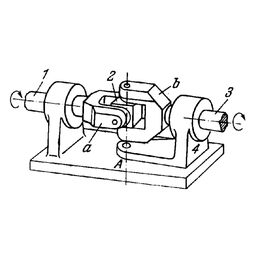

In [ ]:
indx = 3555
print(dataset[indx]["text"])
dataset[indx]["image"]



In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch



In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()


trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


In [ ]:
BATCH_SIZE = 6*5

train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)

total_batches = len(train_dataloader)


In [ ]:
import torch
import time
from IPython.display import clear_output


EPOCH_NUM = 10

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

start_time = time.time()

for epoch in range(EPOCH_NUM):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    batch_start_time = time.time()

    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    batch_time = time.time() - batch_start_time
    elapsed_time = time.time() - start_time
    estimated_total_time = elapsed_time / ((epoch * total_batches + idx + 1) / (EPOCH_NUM * total_batches))
    remaining_time = estimated_total_time - elapsed_time

    print(estimated_total_time)
    print(remaining_time)

    print('epoch = ' + str(epoch))
    print('indx = ' + str(idx) + ' out of ' + str(total_batches))
    print('elapsed time = ' + str(elapsed_time))

    print('-------')
    if idx % 10 == 0:
      clear_output(wait=True)




Loss: 0.99755859375
3314.216549543136
8.83791079878165
epoch = 9
indx = 291 out of 300
elapsed time = 3305.3786387443542
-------
Loss: 1.0029296875
3314.220531465535
7.733181240086196
epoch = 9
indx = 292 out of 300
elapsed time = 3306.4873502254486
-------
Loss: 0.990234375
3314.2182774438647
6.628436554887685
epoch = 9
indx = 293 out of 300
elapsed time = 3307.589840888977
-------
Loss: 0.89990234375
3314.228115734553
5.523713526224583
epoch = 9
indx = 294 out of 300
elapsed time = 3308.7044022083282
-------
Loss: 0.8515625
3314.2430604857022
4.418990747314183
epoch = 9
indx = 295 out of 300
elapsed time = 3309.824069738388
-------
Loss: 0.8935546875
3314.241157995688
3.314241157995639
epoch = 9
indx = 296 out of 300
elapsed time = 3310.9269168376923
-------
Loss: 0.68505859375
3314.2885497763127
2.2095256998509285
epoch = 9
indx = 297 out of 300
elapsed time = 3312.079024076462
-------
Loss: 1.0185546875
3314.2877140216883
1.1047625713404159
epoch = 9
indx = 298 out of 300
elapsed t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

save_directory = "/content/drive/MyDrive/gen mech mecanism/trained_model_captioning"

model.save_pretrained(save_directory)


In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import get_peft_model

model = Blip2ForConditionalGeneration.from_pretrained(save_directory)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

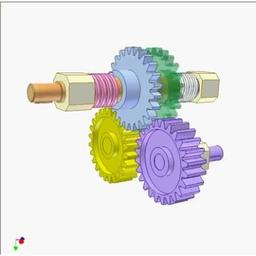

In [ ]:
# load image
example = dataset[6218]
image = example["image"]
image

In [ ]:
from transformers import Blip2ForConditionalGeneration, AutoProcessor
from peft import PeftModel, PeftConfig

# peft_model_id = "ybelkada/blip2-opt-2.7b-football-captions-adapters"
# config = PeftConfig.from_pretrained(peft_model_id)

# model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
# model = PeftModel.from_pretrained(model)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")


In [ ]:
import random

random.seed(82)
random_numbers = [random.randint(0, 8993) for _ in range(10)]

print(random_numbers)


[2371, 8026, 8275, 4786, 2942, 2735, 4270, 2565, 546, 7102]


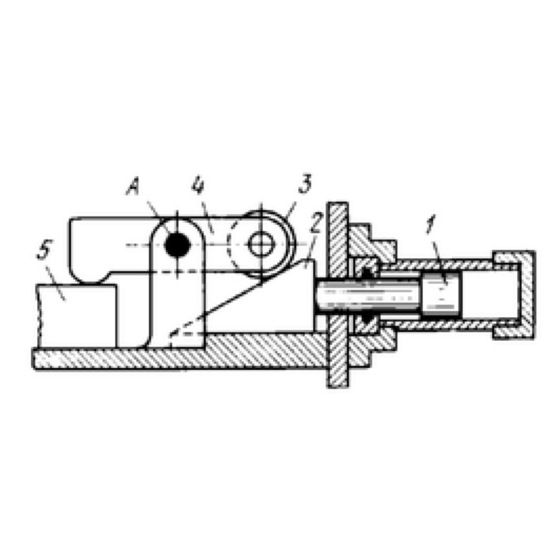

Generated caption: 2d schematics. LEVER-TYPE SCREW-ACTUATED CLAMP. Link 1 is
Real caption: 2d schematics. WEDGE-LEVER MECHANISM OF A HYDRAULIC CLAMPING DEVICE. When piston 1 is moved to the left by the action of fluid delivered to the righht
- - - - - -


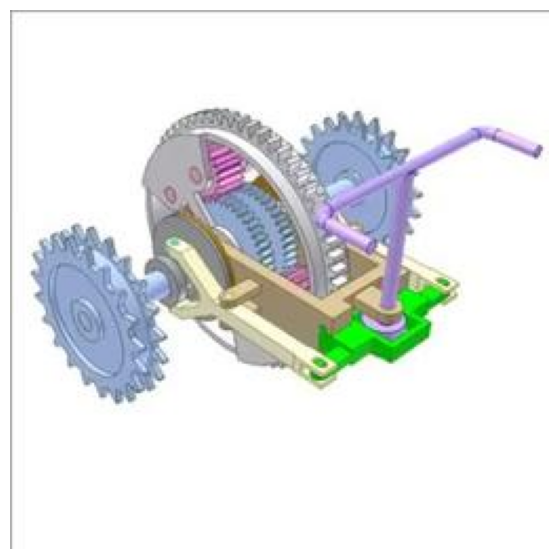

Generated caption: 3D sketch. Transmission with teeth-uncompleted gears. Input: the pink gear. Its number of teeth
Real caption: 3D sketch. Braked differential steering. It is for steering vehicles of continuous tracks. Input: white ring gear of n1 velocity. Output: blue shafts 
- - - - - -


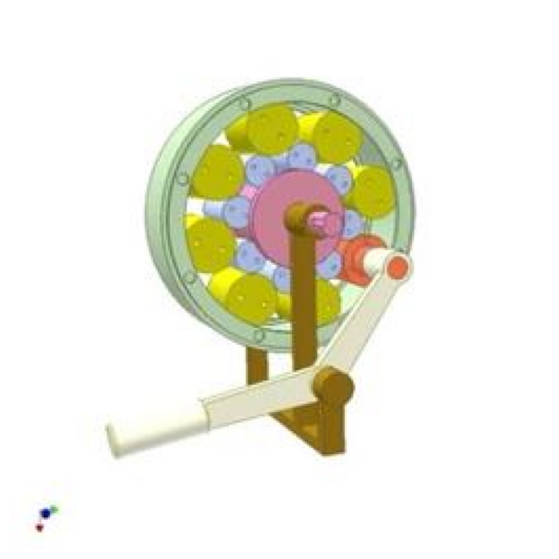

Generated caption: 3D sketch. Machine tool fixture. The pink gear is fixed to the green shaft. The pink gear is fixed
Real caption: 3D sketch. Friction roller drive. The arm and the red roller create normal forces on contact surfaces. Can be used as a controllable clutch. Trasmissi
- - - - - -


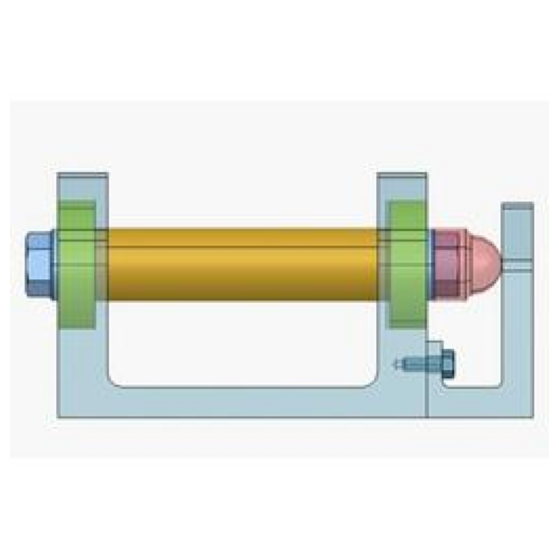

Generated caption: 3D sketch. Machine tool fixture. The fixture holds a workpiece (in orange) in a position where its
Real caption: 3D sketch. Kinematic rotation torque freely engaged with a bearing. View from the front showing a mechanism named kinematic rotation torque freely eng
- - - - - -


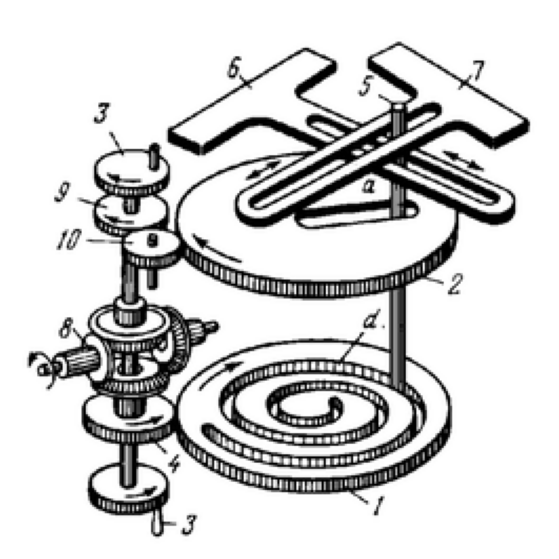

Generated caption: 2d schematics. LEVER-GEAR MECHANISM WITH A DWELL OF THE DR
Real caption: 2d schematics. SLOTTED-LEVER-GEAR SPIRAL-TYPE RECTANGULAR COORDINATE MECHANISM. The mechanism is intended for resolving a vector along coordinate axes
- - - - - -


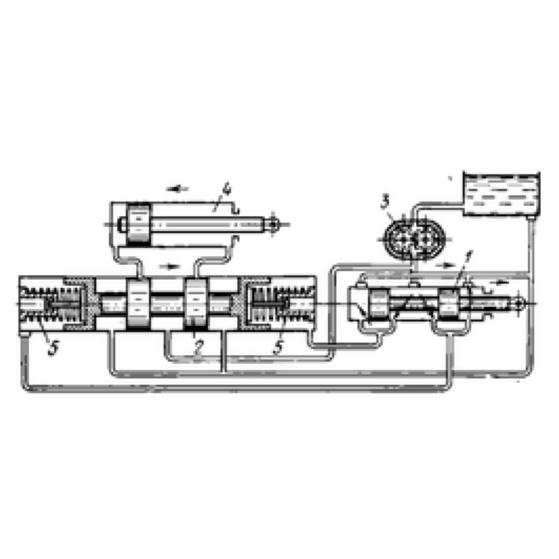

Generated caption: 2d schematics. HYDRAULIC DRIVE MECHANISM OF A MACHINE TO
Real caption: 2d schematics. HYDRAULIC DRIVE MECHANISM WITH A MECHANICALLY OPERATED PILOT VALVE. When pilot valve spool 1 is shifted to the right, fluid is delivere
- - - - - -


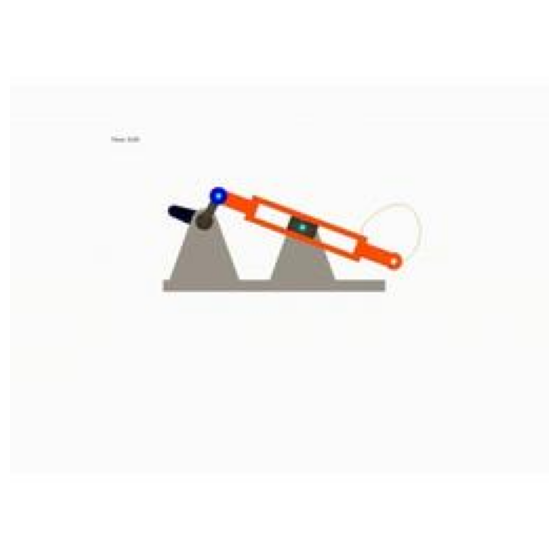

Generated caption: 3D sketch. Six bar linkage. Slider crank kinematic chain connected in parallel with a slider crank -
Real caption: 3D sketch. Inverted Slider Crank.
- - - - - -


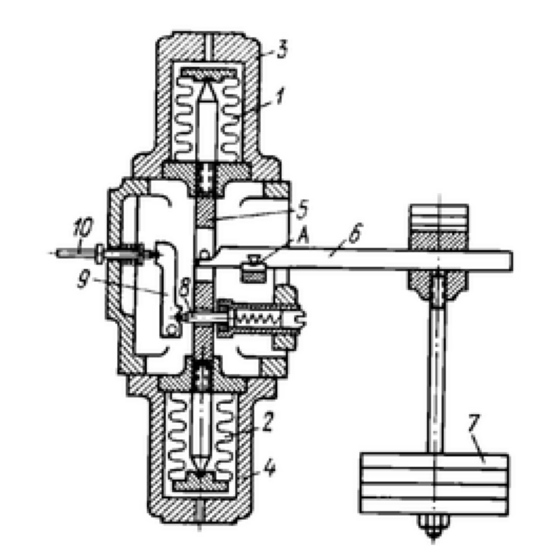

Generated caption: 2d schematics. LEVER-TYPE SCREW-ACTUATED CLAMP. Link 1 is
Real caption: 2d schematics. LEVER MECHANISM OF A GAUGE FOR MEASURING PRESSURE DIFFERENCE. The chambers of cylinders 3 and 4, containing bellows 1 and 2, are connec
- - - - - -


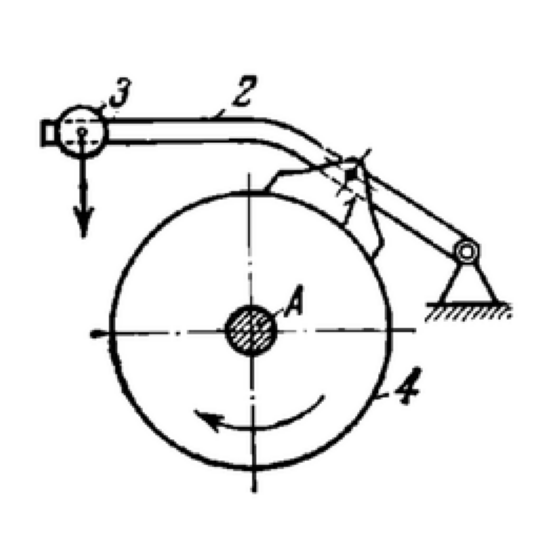

Generated caption: 2d schematics. LEVER-TYPE SCREW-ACTUATED CLAMP. Link 1 is
Real caption: 2d schematics. WEIGHTED-LEVER BLOCK BRAKE. Lever 2 turns about a fixed axis. Shoe 1 is pressed against wheel 4, turning about fixed axis A, by loading
- - - - - -


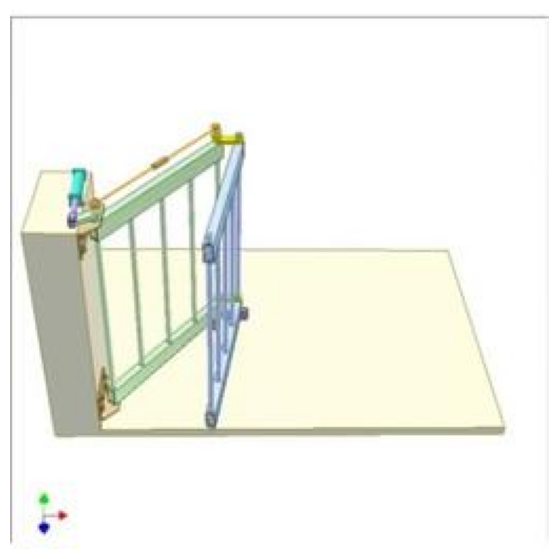

Generated caption: 3D sketch. Gate to open inward uphill. The gate is connected to a slider-crank mechanism. The
Real caption: 3D sketch. Bi-folding gate. Orange conrod, green and upper yellow cranks create a parallelogram mechanism. There is a 4-bar linkage of the pink conrod
- - - - - -


In [ ]:
import torch
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


# prepare image for the model
for i in random_numbers:
    example = dataset[i]
    image = example["image"]
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    # Ensure pixel_values are of the correct type
    pixel_values = pixel_values.to(device, dtype=torch.float32)

    # Ensure the model is on the correct device
    model.to(device)

    generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    fig = plt.figure(figsize=(18/2, 14/2))
    plt.imshow(image)
    plt.axis("off")
    # plt.title(f"Generated caption: {generated_caption}")
    plt.show()
    print(f"Generated caption: {generated_caption}")
    print(f"Real caption: {example['text']}")

    print('- - - - - -')
    # if i == 10:
    #     break




{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'text': '3D sketch. Instrument for directional scaling. Affinograph. Blue, green, violet and pink links create a parallelogram. Green, brown and pink links cre'}